Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/20 16:55:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-12-20 16:55:58,112 - sds - INFO - Calling DataFrame.select(cols=('a',))    
INFO:sds:Calling DataFrame.select(cols=('a',))
2022-12-20 16:55:58,142 - sds - INFO - Calling DataFrame.filter(condition=a=2)
INFO:sds:Calling DataFrame.filter(condition=a=2)


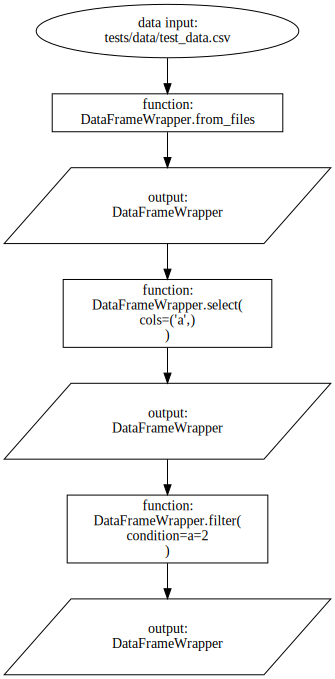

In [1]:
from pyspark.sql import SparkSession
from sds_data_model.dataframe import DataFrameWrapper

spark = (
    SparkSession.builder.master(
        "local",
    )
    .appName(
        "Test context",
    )
    .getOrCreate()
)

dfw = DataFrameWrapper.from_files(
    data_path="tests/data/test_data.csv",
    name="test",
    spark=spark,
)

dfw.call_method("select", "a")

dfw.call_method("filter", "a=2")

dfw.graph

In [2]:
from re import search



In [3]:
dfw.graph.body

['\tdata_path [label="data input:\ntests/data/test_data.csv" shape=oval]\n',
 '\t"DataFrameWrapper.from_files" [label="function:\nDataFrameWrapper.from_files" shape=box]\n',
 '\tDataFrameWrapper [label="output:\nDataFrameWrapper" shape=parallelogram]\n',
 '\tdata_path -> "DataFrameWrapper.from_files"\n',
 '\t"DataFrameWrapper.from_files" -> DataFrameWrapper\n',
 '\t"DataFrameWrapper.select(\ncols=(\'a\',)\n)" [label="function:\nDataFrameWrapper.select(\ncols=(\'a\',)\n)" shape=box]\n',
 '\tDataFrameWrapper_1 [label="output:\nDataFrameWrapper" shape=parallelogram]\n',
 '\tDataFrameWrapper -> "DataFrameWrapper.select(\ncols=(\'a\',)\n)"\n',
 '\t"DataFrameWrapper.select(\ncols=(\'a\',)\n)" -> DataFrameWrapper_1\n',
 '\t"DataFrameWrapper.filter(\ncondition=a=2\n)" [label="function:\nDataFrameWrapper.filter(\ncondition=a=2\n)" shape=box]\n',
 '\tDataFrameWrapper_2 [label="output:\nDataFrameWrapper" shape=parallelogram]\n',
 '\tDataFrameWrapper -> "DataFrameWrapper.filter(\ncondition=a=2\n)"

In [1]:
%pip install shapely


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from shapely.wkb import loads
loads(bytes(bytearray(b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x00j\xf8@\x00\x00\x00\x00\x80O2A\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80O2A\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd63A\x00\x00\x00\x00\x00j\xf8@\x00\x00\x00\x00\xd63A\x00\x00\x00\x00\x00j\xf8@\x00\x00\x00\x00\x80O2A')))

GEOSException: ParseException: Input buffer is smaller than requested object size

AttributeError: type object 'Point' has no attribute 'from_wkb'

In [17]:
from shapely.geometry import Point
from shapely.wkb import loads

loads(bytes(bytearray(Point(1, 1).wkb))).wkt


'POINT (1 1)'

In [27]:
from shapely.wkt import loads
from shapely.geometry.polygon import orient

orient(loads('POLYGON ((100000 1200000, 0 1200000, 0 1300000, 100000 1300000, 100000 1200000))'), sign=0.0).wkt

/home/jamesduffy/.pyenv/versions/3.8.8/lib/python3.8/site-packages/shapely/geometry/polygon.py:333: RuntimeWarning: divide by zero encountered in double_scalars
  if signed_area(ring) / s >= 0.0:


'POLYGON ((100000 1200000, 100000 1300000, 0 1300000, 0 1200000, 100000 1200000))'

In [26]:
orient(loads('POLYGON ((100000 1200000, 100000 1300000, 0 1300000, 0 1200000, 100000 1200000))')).wkt

'POLYGON ((100000 1200000, 100000 1300000, 0 1300000, 0 1200000, 100000 1200000))'